In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import pandas
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#parametros para vocabulario y la red
vocab_size = 15000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8
epochs = 10
batch_size = 64

In [3]:
#lectura del dataset
DataSet=pandas.read_csv("c:\\AttributionDL\\AttributionDataset.csv", delimiter = ',')
#los datos son reordenados al azar
DataSet=DataSet.sample(frac = 1).reset_index(drop=True)#to shuffle your dataframe in-place and reset the index

In [4]:
print (DataSet)

              Autor                                              Texto
0      GeorgeDonald  A large garden of any sort is valuable, but an...
1         MarkTwain  "No, I haven't." I see myself there warn't no ...
2         MarkTwain  However, had not we the seductive program stil...
3        LouisTracy  David narrowly escaped an apoplectic seizure. ...
4      GeorgeDonald  "What a funny name!" "It's a very nice name," ...
..              ...                                                ...
955       MarkTwain  The way I was looked upon was odd, but it was\...
956    GeorgeDonald  She felt sad, weak, and, perhaps, for the firs...
957  CharlesDickens  I was tired of reading, and dead sleepy; but h...
958    GeorgeVaizey  She had feared. Ever since receiving her frien...
959      LouisTracy  "Haven't you heard of Kosnovia? It is a little...

[960 rows x 2 columns]


In [5]:
articles = []
labels = []
#se extraen los datos a cada una de las listas
for i in range(len(DataSet)) : 
    labels.append(DataSet.loc[i, "Autor"])
    articles.append(DataSet.loc[i, "Texto"])

In [6]:
#se crea el vocabulario
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(articles)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108091 unique tokens.


In [7]:
#los textos se convierten a numeros 
TextToSequencesArticles = tokenizer.texts_to_sequences(articles) 
#despues se fijan a una misma longitud (200)
TextToSequencesArticles = pad_sequences(TextToSequencesArticles, maxlen=max_length)
print('Shape of data tensor:', TextToSequencesArticles.shape)
#las etiquetas de autor son convertidas a one-hot encode
CategoricalToNumbersLabels = pandas.get_dummies(labels)
print('Shape of label tensor:', CategoricalToNumbersLabels.shape)

Shape of data tensor: (960, 200)
Shape of label tensor: (960, 7)


In [8]:
#creando conjuntos de entrenamiento y prueba
train_articles,validation_articles,train_labels,validation_labels = train_test_split(TextToSequencesArticles,CategoricalToNumbersLabels, test_size = 0.20, random_state = 42)
print(train_articles.shape,train_labels.shape)
print(validation_articles.shape,validation_labels.shape)

(768, 200) (768, 7)
(192, 200) (192, 7)


In [9]:
#creando la red 
model=Sequential()
model.add(Embedding(vocab_size,embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          960000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 1,026,951
Trainable params: 1,026,951
Non-trainable params: 0
_________________________________________________________________


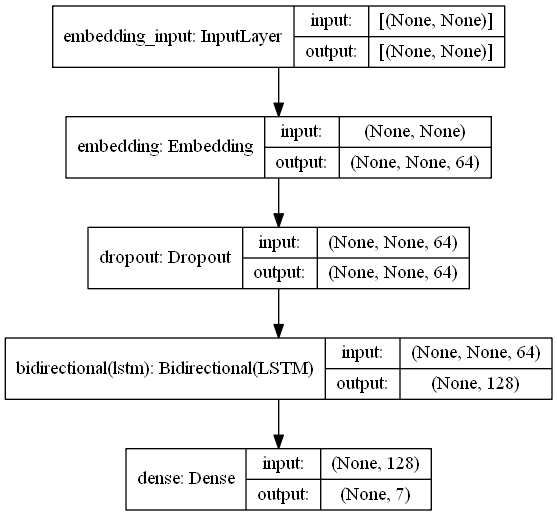

In [10]:
#graficando el modelo
tf.keras.utils.plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [11]:
#compilando la red
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#entrenando la red
#history = model.fit(train_articles, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
#history = model.fit(train_articles, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(train_articles, train_labels, epochs=epochs,validation_data=(validation_articles,validation_labels))

Epoch 1/10
24/24 [==============================] - 5s 147ms/step - loss: 1.9426 - accuracy: 0.1677 - val_loss: 1.9429 - val_accuracy: 0.1458
Epoch 2/10
24/24 [==============================] - 2s 94ms/step - loss: 1.9184 - accuracy: 0.2404 - val_loss: 1.9216 - val_accuracy: 0.1458
Epoch 3/10
24/24 [==============================] - 2s 96ms/step - loss: 1.8421 - accuracy: 0.2548 - val_loss: 1.8709 - val_accuracy: 0.1875
Epoch 4/10
24/24 [==============================] - 2s 97ms/step - loss: 1.7023 - accuracy: 0.3460 - val_loss: 1.6977 - val_accuracy: 0.3073
Epoch 5/10
24/24 [==============================] - 2s 97ms/step - loss: 1.5124 - accuracy: 0.3889 - val_loss: 1.8306 - val_accuracy: 0.2969
Epoch 6/10
24/24 [==============================] - 2s 95ms/step - loss: 1.3461 - accuracy: 0.4930 - val_loss: 1.7226 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 2s 98ms/step - loss: 1.0889 - accuracy: 0.6427 - val_loss: 1.5090 - val_accuracy: 0.3438
Epoch 8/10
2

In [13]:
#evaluando la red
accr = model.evaluate(validation_articles,validation_labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 0s 24ms/step - loss: 1.5844 - accuracy: 0.3281
Test set
  Loss: 1.584
  Accuracy: 0.328
